### GENE CLUSTERING BASED ON GNN EMBEDDINGS (T_SNE)

Processed data shape: (11939, 4161)
Graph: 4161 nodes, 1432 edges
Epoch 1/100, Loss: 0.44359540939331055
Epoch 2/100, Loss: 0.4314224123954773
Epoch 3/100, Loss: 0.4293205440044403
Epoch 4/100, Loss: 0.42842864990234375
Epoch 5/100, Loss: 0.4276270568370819
Epoch 6/100, Loss: 0.42688292264938354
Epoch 7/100, Loss: 0.42617926001548767
Epoch 8/100, Loss: 0.4253939986228943
Epoch 9/100, Loss: 0.42444339394569397
Epoch 10/100, Loss: 0.4232863485813141
Epoch 11/100, Loss: 0.4217734634876251
Epoch 12/100, Loss: 0.4199278652667999
Epoch 13/100, Loss: 0.4178324043750763
Epoch 14/100, Loss: 0.41559863090515137
Epoch 15/100, Loss: 0.4133160710334778
Epoch 16/100, Loss: 0.4110093414783478
Epoch 17/100, Loss: 0.4086095690727234
Epoch 18/100, Loss: 0.40599676966667175
Epoch 19/100, Loss: 0.40311065316200256
Epoch 20/100, Loss: 0.3999936878681183
Epoch 21/100, Loss: 0.39673787355422974
Epoch 22/100, Loss: 0.3934116065502167
Epoch 23/100, Loss: 0.39002156257629395
Epoch 24/100, Loss: 0.38653099536895

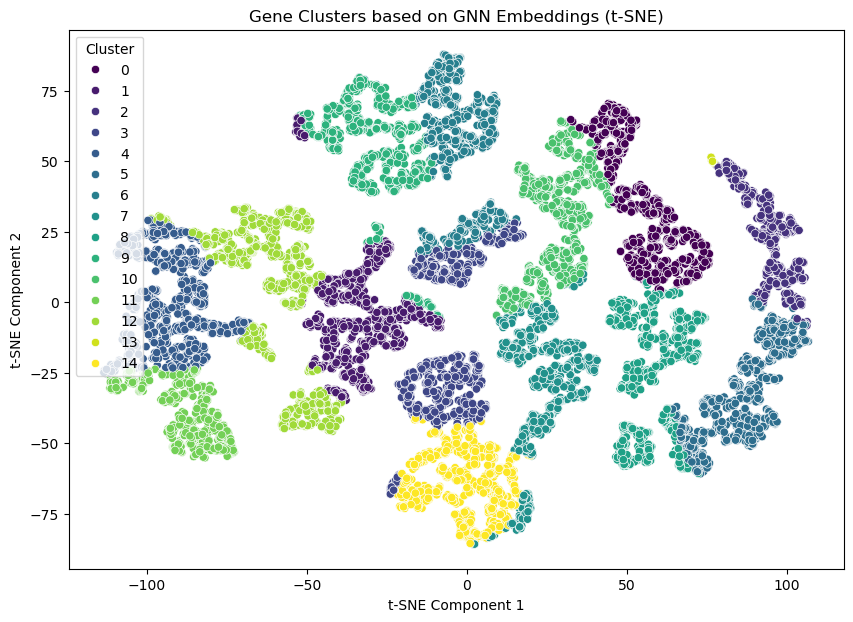

In [10]:
import scanpy as sc
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import numpy as np
from scipy.sparse import coo_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Load the matrix and preprocess data
def load_and_preprocess_data(matrix_path):
    adata = sc.read_mtx(matrix_path)
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    print("Processed data shape:", adata.shape)
    return adata

# Construct GRN from the gene expression data
def construct_grn(adata, threshold=0.3) -> nx.Graph:
    genes = adata.var_names
    expression_matrix = adata.X.T.toarray()
    correlation_matrix = np.corrcoef(expression_matrix)
    
    # Set correlations below threshold to zero
    correlation_matrix[np.abs(correlation_matrix) < threshold] = 0

    # Initialize graph and add nodes
    G = nx.Graph()
    G.add_nodes_from(genes)

    # Add edges based on correlation threshold
    for i, gene1 in enumerate(genes):
        for j, gene2 in enumerate(genes):
            if i != j and correlation_matrix[i, j] != 0:
                G.add_edge(gene1, gene2, weight=correlation_matrix[i, j])

    if G.number_of_edges() == 0:
        print("Warning: No edges were added to the graph. Try lowering the correlation threshold.")
    else:
        print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    return G

# Prepare graph data for GNN
def prepare_graph_data_for_gnn(adata, G):
    gene_to_idx = {gene: idx for idx, gene in enumerate(adata.var_names)}

    edge_index = torch.tensor(
        [(gene_to_idx[gene1], gene_to_idx[gene2]) for gene1, gene2 in G.edges
         if gene1 in gene_to_idx and gene2 in gene_to_idx],
        dtype=torch.long
    ).t().contiguous()

    expression_matrix = torch.tensor(adata.X.toarray(), dtype=torch.float)
    data = Data(x=expression_matrix, edge_index=edge_index)
    return data

# Define and train the GNN model
class SimpleGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, input_dim)  # Reconstruction layer

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

def train_gnn_model(data, epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SimpleGCN(input_dim=data.x.shape[1], hidden_dim=64).to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.smooth_l1_loss(out, data.x)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

    return model

# Step 1: Extract embeddings
def extract_embeddings(model, data):
    model.eval()
    with torch.no_grad():
        embeddings = model(data.x, data.edge_index).cpu().numpy()
    return embeddings

# Step 2: Dimensionality reduction with t-SNE
def reduce_dimensions_tsne(embeddings, n_components=2, perplexity=30):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=0)
    embeddings_2d = tsne.fit_transform(embeddings)
    return embeddings_2d

# Step 3: Clustering
def perform_clustering(embeddings, n_clusters=15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit_predict(embeddings)
    return clusters

# Step 4: Visualize clusters
def plot_clusters(embeddings_2d, clusters):
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=embeddings_2d[:, 0], 
        y=embeddings_2d[:, 1], 
        hue=clusters, 
        palette="viridis", 
        legend="full"
    )
    plt.title("Gene Clusters based on GNN Embeddings (t-SNE)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(title="Cluster")
    plt.show()

# Main script
data = load_and_preprocess_data("./data/matrix.mtx")
graph = construct_grn(data)
gnn_data = prepare_graph_data_for_gnn(data, graph)
model = train_gnn_model(gnn_data)

embeddings = extract_embeddings(model, gnn_data)
embeddings_2d = reduce_dimensions_tsne(embeddings, n_components=2, perplexity=30)
clusters = perform_clustering(embeddings, n_clusters=15)
plot_clusters(embeddings_2d, clusters)


### DIFFERENTIAL GENE EXPRESSION TESTING CODE

In [11]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Perform Differential Gene Expression Analysis
def differential_gene_expression(adata, condition_labels):
    group1 = adata.X[condition_labels == 0].toarray()
    group2 = adata.X[condition_labels == 1].toarray()
    
    pvals = []
    fold_changes = []
    
    for i in range(group1.shape[1]):
        stat, pval = ttest_ind(group1[:, i], group2[:, i])
        pvals.append(pval)
        
        mean1 = np.mean(group1[:, i])
        mean2 = np.mean(group2[:, i])
        fold_change = np.log2((mean2 + 1e-9) / (mean1 + 1e-9))  # Avoid divide by zero
        fold_changes.append(fold_change)
    
    results = pd.DataFrame({
        'gene': adata.var_names,
        'pval': pvals,
        'log2_fold_change': fold_changes
    })
    
    results['pval_adj'] = multipletests(results['pval'], method='fdr_bh')[1]
    
    return results

# Example condition labels (replace with actual labels if available)
condition_labels = np.random.randint(0, 2, data.shape[0])

# Perform DGE
dge_results = differential_gene_expression(data, condition_labels)
significant_genes = dge_results[dge_results['pval_adj'] < 0.05]

# Display significant results
print("Significant Differentially Expressed Genes:")
print(significant_genes.head())


Significant Differentially Expressed Genes:
Empty DataFrame
Columns: [gene, pval, log2_fold_change, pval_adj]
Index: []


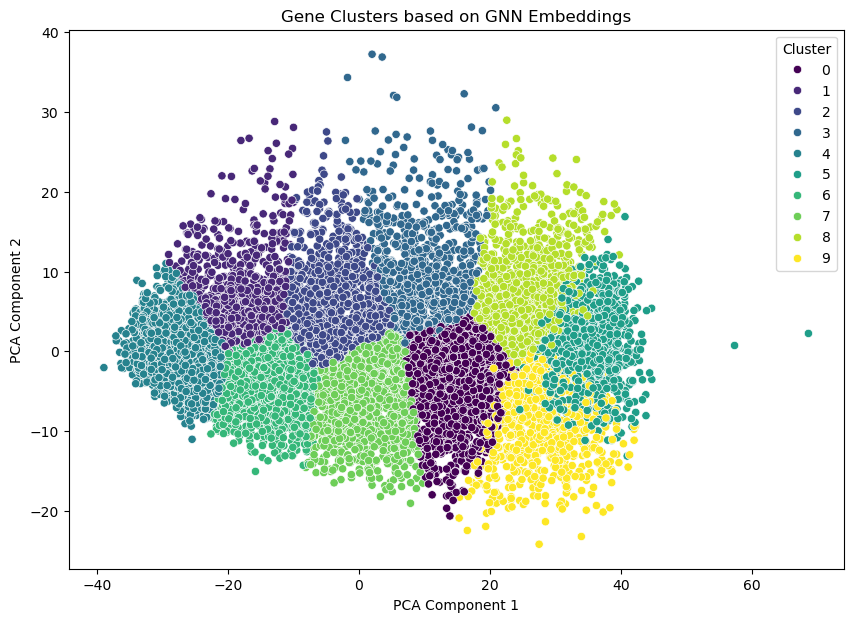

In [8]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Extract embeddings
def extract_embeddings(model, data):
    model.eval()
    with torch.no_grad():
        embeddings = model(data.x, data.edge_index).cpu().numpy()
    return embeddings

# Step 2: Dimensionality reduction with PCA (optional)
def reduce_dimensions(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    embeddings_2d = pca.fit_transform(embeddings)
    return embeddings_2d

# Step 3: Clustering
def perform_clustering(embeddings, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit_predict(embeddings)
    return clusters

# Step 4: Visualize clusters
def plot_clusters(embeddings_2d, clusters):
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=embeddings_2d[:, 0], 
        y=embeddings_2d[:, 1], 
        hue=clusters, 
        palette="viridis", 
        legend="full"
    )
    plt.title("Gene Clusters based on GNN Embeddings")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Cluster")
    plt.show()

# Execute clustering steps
embeddings = extract_embeddings(model, gnn_data)
embeddings_2d = reduce_dimensions(embeddings, n_components=2)
clusters = perform_clustering(embeddings, n_clusters=10)
plot_clusters(embeddings_2d, clusters)


In [55]:
# Calculate the variance of each dimension in the embeddings
embedding_variance = np.var(embeddings, axis=0)
print("Variance across embedding dimensions:\n", embedding_variance)
print("Total variance:", np.sum(embedding_variance))


Variance across embedding dimensions:
 [0.3994561  0.38146695 0.01272646 ... 0.03936611 0.16847754 0.0859539 ]
Total variance: 432.1321


In [1]:
import gseapy as gp
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

In [12]:
import gseapy as gp
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch_geometric.data import Data
import networkx as nx

# Step 1: Construct GRN and define edge_index based on correlations
import numpy as np
import torch

import numpy as np
import torch

def construct_grn(data, threshold=0.3):
    genes = data.var_names
    
    # Force conversion to a dense float array and transpose
    expression_matrix = np.array(data.X.todense(), dtype=float).T if hasattr(data.X, 'todense') else np.array(data.X, dtype=float).T
    
    # Verify data type and shape
    print(f"Data type of expression_matrix: {expression_matrix.dtype}")
    print(f"Shape of expression_matrix before filtering: {expression_matrix.shape}")
    
    # Remove columns with constant values or NaNs
    mask = np.all(expression_matrix == expression_matrix[:, [0]], axis=0) | np.isnan(expression_matrix).any(axis=0)
    expression_matrix = expression_matrix[:, ~mask]
    
    print(f"Shape of expression_matrix after filtering: {expression_matrix.shape}")

    # Ensure matrix has at least two genes and two cells
    if expression_matrix.shape[0] < 2 or expression_matrix.shape[1] < 2:
        raise ValueError("expression_matrix must have at least two genes and two cells for correlation calculation.")
    
    # Calculate correlation matrix with rowvar=False
    correlation_matrix = np.corrcoef(expression_matrix, rowvar=False)
    
    # Set correlations below the threshold to zero
    correlation_matrix[np.abs(correlation_matrix) < threshold] = 0

    # Create edge list
    edge_list = []
    for i in range(len(genes)):
        for j in range(i + 1, len(genes)):
            if correlation_matrix[i, j] != 0:
                edge_list.append([i, j])
    
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    if edge_index.numel() == 0:
        print("Warning: No edges created. Try lowering the correlation threshold.")
    else:
        print(f"Number of edges created: {edge_index.size(1)}")
    
    return edge_index



# Extract embeddings from the trained GNN model
def extract_embeddings(model, graph_data):
    model.eval()
    with torch.no_grad():
        embeddings = model(graph_data.x, graph_data.edge_index).cpu().numpy()
    return embeddings

# Perform clustering on embeddings
def perform_clustering(embeddings, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit_predict(embeddings)
    return clusters

# Run GSEA for each cluster
def run_gsea_for_clusters(gene_names, clusters, gene_sets="GO_Biological_Process_2021"):
    gsea_results = {}

    for cluster_label in set(clusters):
        genes_in_cluster = [gene_names[i] for i, label in enumerate(clusters) if label == cluster_label]
        
        print(f"Cluster {cluster_label} contains {len(genes_in_cluster)} genes.")
        
        if len(genes_in_cluster) > 5:  # Adjust minimum size if needed
            print(f"Running GSEA for cluster {cluster_label}...")
            gsea_result = gp.enrichr(
                gene_list=genes_in_cluster,
                gene_sets=gene_sets,
                organism="Human",
                outdir=None,
                cutoff=10
            )
            gsea_results[cluster_label] = gsea_result.results.head(10)
        else:
            print(f"Cluster {cluster_label} is too small for GSEA.")

    return gsea_results

# Filter gene expression data in AnnData and separate graph data in PyTorch Geometric format
def filter_data_for_valid_genes(data, graph_data):
    valid_gene_indices = [i for i in range(data.shape[1])]

    data.X = data.X[:, valid_gene_indices]

    graph_data.edge_index = graph_data.edge_index[:, 
                                                  (graph_data.edge_index[0] < len(valid_gene_indices)) & 
                                                  (graph_data.edge_index[1] < len(valid_gene_indices))]

    return data, graph_data, valid_gene_indices

# Main execution block

# Step 1: Define edge_index using GRN construction
edge_index = construct_grn(data)

# Step 2: Reduce dimensionality of x with PCA to 64 components
pca = PCA(n_components=64)
reduced_x = pca.fit_transform(data.X.T)
graph_data = Data(x=torch.tensor(reduced_x.copy(), dtype=torch.float), edge_index=edge_index)

# Step 3: Filter data and graph_data for valid genes
data, graph_data, valid_gene_indices = filter_data_for_valid_genes(data, graph_data)

# Step 4: Extract gene names based on valid indices
gene_names = data.var_names[valid_gene_indices]

# Print length for verification
print(f"Number of genes: {len(gene_names)}, Number of nodes in graph_data.x: {graph_data.x.size(0)}")

# Step 5: Extract embeddings and validate alignment
embeddings = extract_embeddings(model, graph_data)
print(f"Number of embeddings: {len(embeddings)}")
assert len(embeddings) == len(gene_names), "Mismatch between embeddings and gene names."

# Step 6: Perform clustering
clusters = perform_clustering(embeddings, n_clusters=10)
assert len(clusters) == len(gene_names), "Mismatch between clusters and gene names."

# Step 7: Run GSEA on the clusters
gsea_results = run_gsea_for_clusters(gene_names, clusters)

# Step 8: Display GSEA results


for cluster_label, result in gsea_results.items():
    print(f"\nCluster {cluster_label} GSEA Results:")
    if isinstance(result, pd.DataFrame) and not result.empty:
        display(result.head(10))  # Display the top 10 results if available
    else:
        print(f"No significant results found for Cluster {cluster_label}.")


Data type of expression_matrix: float64
Shape of expression_matrix before filtering: (4161, 11939)
Shape of expression_matrix after filtering: (4161, 11938)
Number of edges created: 2198170
Number of genes: 4161, Number of nodes in graph_data.x: 4161


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4161x64 and 4161x64)